In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
# --- Step 1: Load & Prepare Dataset ---
df = pd.read_csv("advertising.csv")

In [ ]:
# Select 2 features only for visualization
df = df[['Age', 'Daily Internet Usage', 'Clicked on Ad']]

In [ ]:
# Features and target
X = df.drop('Clicked on Ad', axis=1).values
y = df['Clicked on Ad'].values
y = np.where(y == 0, -1, 1)  # Convert labels to -1 and 1 for SVM



In [ ]:
# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:

# --- Step 2: Kernel Functions ---
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def rbf_kernel(x1, x2, gamma):
    return np.exp(-gamma * np.linalg.norm(x1 - x2)**2)

In [ ]:
# --- Step 3: SVM with Kernel, C, Gamma ---
class SVM_Kernel:
    def __init__(self, kernel='linear', C=1.0, gamma=2.0):
        self.C = C
        self.gamma = gamma
        if kernel == 'linear':
            self.kernel = linear_kernel
        elif kernel == 'rbf':
            self.kernel = lambda x1, x2: rbf_kernel(x1, x2, gamma)
        else:
            raise ValueError("Only 'linear' and 'rbf' kernels are supported")

    def fit(self, X, y, epochs=1000, lr=0.001):
        n_samples, n_features = X.shape
        self.X = X
        self.y = y
        self.alpha = np.zeros(n_samples)
        self.b = 0

        # Precompute Kernel Matrix
        self.K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                self.K[i, j] = self.kernel(X[i], X[j])

        # Gradient descent on dual variables
        for _ in range(epochs):
            for i in range(n_samples):
                condition = y[i] * (np.sum(self.alpha * y * self.K[:, i]) + self.b)
                if condition < 1:
                    self.alpha[i] += lr * (1 - condition)
                    self.alpha[i] = min(max(self.alpha[i], 0), self.C)  # Clip α between 0 and C

        # Support vectors
        self.support_indices = self.alpha > 1e-5
        self.support_vectors = X[self.support_indices]
        self.support_labels = y[self.support_indices]
        self.support_alpha = self.alpha[self.support_indices]

    def project(self, X):
        result = []
        for x in X:
            val = 0
            for i in range(len(self.support_alpha)):
                val += self.support_alpha[i] * self.support_labels[i] * self.kernel(self.support_vectors[i], x)
            result.append(val + self.b)
        return np.array(result)

    def predict(self, X):
        return np.sign(self.project(X))

In [ ]:
# --- Step 4: Train the Model ---
svm = SVM_Kernel(kernel='rbf', C=1.0, gamma=1.0)
svm.fit(X_train, y_train)


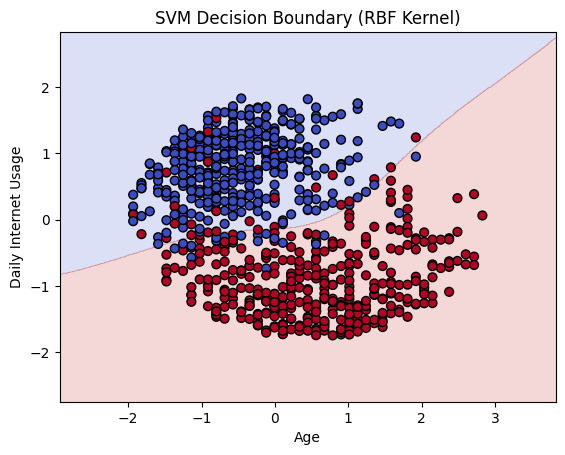

In [ ]:

# --- Step 5: Visualize Decision Boundary ---
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))

    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=40, edgecolors='k')
    plt.title("SVM Decision Boundary (RBF Kernel)")
    plt.xlabel("Age")
    plt.ylabel("Daily Internet Usage")
    plt.show()

plot_decision_boundary(svm, X_train, y_train)


In [ ]:
# --- Step 6: Accuracy ---
predictions = svm.predict(X_test)
accuracy = np.mean(predictions == y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 86.00%
